## Meaningful feature
- 1. Î∂ÄÏ±Ñ ÎåÄÎπÑ ÏÜåÎìù ÎπÑÏú® (DTI ratio - Ïõî ÏÜåÎìù Í∏∞Ï§Ä)

- 2. Î¶¨Î≥ºÎπô ÌôúÏö©ÎèÑ (Ï¥ù ÌïúÎèÑ ÎåÄÎπÑ ÏÇ¨Ïö© ÎπÑÏú®)

- 3. Í∞ÄÏö© Ïã†Ïö© ÎπÑÏú® (ÎÇ®ÏùÄ Ïã†Ïö© ÌïúÎèÑ ÎπÑÏú®)

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [159]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


## Base

In [160]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [161]:
data.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'zip_code', 'installment', 'fico_range_low',
       'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'revol_util',
       'revol_bal', 'total_acc', 'credit_history_years', 'loan_status'],
      dtype='object')

In [162]:
## Train set Î∞îÍæ∏Í∏∞Í∏∞
data['annual_inc_adj'] = data['annual_inc'].replace(0, 1e-6)

# 1. Î∂ÄÏ±Ñ ÎåÄÎπÑ ÏÜåÎìù ÎπÑÏú® (DTI ratio - Ïõî ÏÜåÎìù Í∏∞Ï§Ä)
data['debt_to_income_ratio'] = data['installment'] / (data['annual_inc_adj'] / 12)

# 2. Î¶¨Î≥ºÎπô ÌôúÏö©ÎèÑ (Ï¥ù ÌïúÎèÑ ÎåÄÎπÑ ÏÇ¨Ïö© ÎπÑÏú®)
data['total_rev_hi_lim_adj'] = data['total_rev_hi_lim'].replace(0, 1e-6)
data['utilization_ratio'] = data['revol_bal'] / data['total_rev_hi_lim_adj']

# 3. Í∞ÄÏö© Ïã†Ïö© ÎπÑÏú® (ÎÇ®ÏùÄ Ïã†Ïö© ÌïúÎèÑ ÎπÑÏú®)
data['open_to_limit_ratio'] = data['bc_open_to_buy'] / data['total_rev_hi_lim_adj']

# ‚úÖ ÌïÑÏöî ÏóÜÏñ¥ÏßÑ Î≥¥Ï†ï Ïª¨Îüº Ï†úÍ±∞
data.drop(columns=['annual_inc_adj', 'total_rev_hi_lim_adj'], inplace=True)

## Test set Î∞îÍæ∏Í∏∞Í∏∞
test_data['annual_inc_adj'] = test_data['annual_inc'].replace(0, 1e-6)

# 1. Î∂ÄÏ±Ñ ÎåÄÎπÑ ÏÜåÎìù ÎπÑÏú® (DTI ratio - Ïõî ÏÜåÎìù Í∏∞Ï§Ä)
test_data['debt_to_income_ratio'] = test_data['installment'] / (test_data['annual_inc_adj'] / 12)

# 2. Î¶¨Î≥ºÎπô ÌôúÏö©ÎèÑ (Ï¥ù ÌïúÎèÑ ÎåÄÎπÑ ÏÇ¨Ïö© ÎπÑÏú®)
test_data['total_rev_hi_lim_adj'] = test_data['total_rev_hi_lim'].replace(0, 1e-6)
test_data['utilization_ratio'] = test_data['revol_bal'] / test_data['total_rev_hi_lim_adj']

# 3. Í∞ÄÏö© Ïã†Ïö© ÎπÑÏú® (ÎÇ®ÏùÄ Ïã†Ïö© ÌïúÎèÑ ÎπÑÏú®)
test_data['open_to_limit_ratio'] = test_data['bc_open_to_buy'] / test_data['total_rev_hi_lim_adj']

# ‚úÖ ÌïÑÏöî ÏóÜÏñ¥ÏßÑ Î≥¥Ï†ï Ïª¨Îüº Ï†úÍ±∞
test_data.drop(columns=['annual_inc_adj', 'total_rev_hi_lim_adj'], inplace=True)

In [163]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [164]:
"""to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']

scaler = MinMaxScaler()
data_x_scaled = data_x.copy()
data_x_scaled[to_scale] = scaler.fit_transform(data_x_scaled[to_scale])

X_test[to_scale] = scaler.transform(X_test[to_scale])"""

"to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']\n\nscaler = MinMaxScaler()\ndata_x_scaled = data_x.copy()\ndata_x_scaled[to_scale] = scaler.fit_transform(data_x_scaled[to_scale])\n\nX_test[to_scale] = scaler.transform(X_test[to_scale])"

In [165]:
to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']
data_x_scaled = data_x.copy()

for col in to_scale:
    data_x_scaled[col] = np.log1p(data_x_scaled[col])  # log(1 + x) ‚Üí 0 Í∞í ÎåÄÏùë
    X_test[col] = np.log1p(X_test[col])

In [166]:
data.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'zip_code', 'installment', 'fico_range_low',
       'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'revol_util',
       'revol_bal', 'total_acc', 'credit_history_years', 'loan_status',
       'debt_to_income_ratio', 'utilization_ratio', 'open_to_limit_ratio'],
      dtype='object')

In [167]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x_scaled, data_y, test_size=0.13, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 1295091 samples (87.0%)
Validation size: 193520 samples (13.0%)
Test size: 372153 samples (25.0%)


In [168]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ‚úÖ `.values`Î°ú NumPy Î∞∞Ïó¥ Î≥ÄÌôò
#scale_pos_weight = neg / pos  # ÌÅ¥ÎûòÏä§ ÎπÑÏú® Í≥ÑÏÇ∞

# 1Ô∏è‚É£ XGBoost Î™®Îç∏ Ï†ïÏùò
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.49199	validation_1-logloss:0.49202
[1]	validation_0-logloss:0.48743	validation_1-logloss:0.48749
[2]	validation_0-logloss:0.48300	validation_1-logloss:0.48307
[3]	validation_0-logloss:0.47868	validation_1-logloss:0.47877
[4]	validation_0-logloss:0.47447	validation_1-logloss:0.47459
[5]	validation_0-logloss:0.47037	validation_1-logloss:0.47051
[6]	validation_0-logloss:0.46637	validation_1-logloss:0.46653
[7]	validation_0-logloss:0.46246	validation_1-logloss:0.46265
[8]	validation_0-logloss:0.45866	validation_1-logloss:0.45886
[9]	validation_0-logloss:0.45494	validation_1-logloss:0.45515
[10]	validation_0-logloss:0.45131	validation_1-logloss:0.45154
[11]	validation_0-logloss:0.44776	validation_1-logloss:0.44801
[12]	validation_0-logloss:0.44429	validation_1-logloss:0.44456
[13]	validation_0-logloss:0.44090	validation_1-logloss:0.44119
[14]	validation_0-logloss:0.43759	validation_1-logloss:0.43788
[15]	validation_0-logloss:0.43434	validation_1-logloss:0.43466
[1

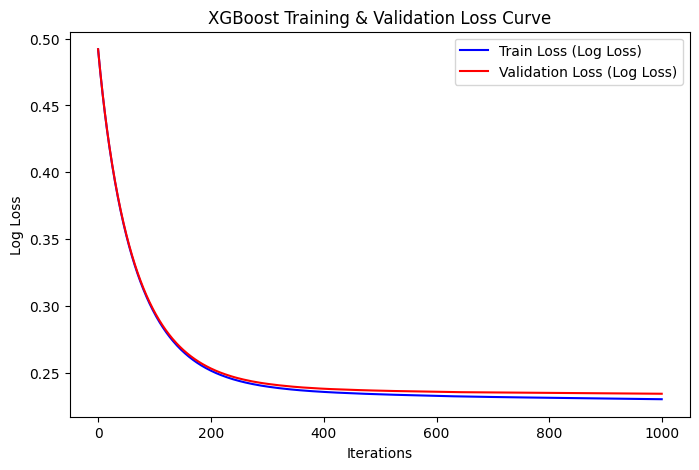

üîπ Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93    299557
           1       0.66      0.87      0.75     72596

    accuracy                           0.89    372153
   macro avg       0.81      0.88      0.84    372153
weighted avg       0.91      0.89      0.89    372153



In [169]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss Ï†ÄÏû•
    verbose=True
)

# 3Ô∏è‚É£ ÌïôÏäµ Í≥ºÏ†ïÏóêÏÑú Ï†ÄÏû•Îêú Train & Validation Loss Í∞ÄÏ†∏Ïò§Í∏∞
evals_result = model.evals_result()  # üîπ Î≥ÄÍ≤ΩÎêú ÏΩîÎìú (ÌïôÏäµ ÌõÑ Í≤∞Í≥º ÌôïÏù∏)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4Ô∏è‚É£ Train & Validation Loss ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5Ô∏è‚É£ ÏòàÏ∏° Î∞è ÌèâÍ∞Ä
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRCÏóê ÌïÑÏöî

threshold = 0.3 
y_pred = (y_prob >= threshold).astype(int)

# üîπ Classification Report Ï∂úÎ†•
print("üîπ Classification Report:")
print(classification_report(y_test, y_pred))

# 6Ô∏è‚É£ ROC Curve & AUC-ROC Í≥ÑÏÇ∞
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7Ô∏è‚É£ Precision-Recall Curve & AU-PRC Í≥ÑÏÇ∞
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [170]:
from sklearn.metrics import confusion_matrix
# confusion matrix Í≥ÑÏÇ∞
cm = confusion_matrix(y_test, y_pred)

# Ìñâ: Ïã§Ï†úÍ∞í (y_test), Ïó¥: ÏòàÏ∏°Í∞í (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("‚úÖ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

‚úÖ Confusion Matrix
[[267163  32394]
 [  9737  62859]]

True Positives (TP): 62859
False Positives (FP): 32394
True Negatives (TN): 267163
False Negatives (FN): 9737


### UnderSampling

In [171]:
print(f"Train dataset : {data['loan_status'].value_counts()}, \n\nTest dataset : {len(test_data)}")

Train dataset : loan_status
0    1198226
1     290385
Name: count, dtype: int64, 

Test dataset : 372153


In [172]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x_scaled, data_y, test_size=0.13, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 1295091 samples (87.0%)
Validation size: 193520 samples (13.0%)
Test size: 372153 samples (25.0%)


In [173]:
# ÌÅ¥ÎûòÏä§Î≥Ñ ÏÉòÌîå Í∞úÏàò ÌôïÏù∏
print("Original class distribution:\n", y_train.value_counts())

# Ïñ∏ÎçîÏÉòÌîåÎßÅ Ï†ÅÏö© (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

# Í≤∞Í≥º ÌôïÏù∏ (Í∞Å Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ÄÌôò (ÌïÑÏöîÌïòÎ©¥)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# Ïñ∏ÎçîÏÉòÌîåÎßÅ Î∞è Ïò§Î≤ÑÏÉòÌîåÎßÅ Í≤∞Í≥º ÌôïÏù∏
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              1042456
1               252635
Name: count, dtype: int64
Original data size: 1488611 samples
Undersampled data size: 505270 samples

Undersampling imbalance check
loan_status
0    252635
1    252635
Name: count, dtype: int64


In [174]:
X_train = data_under.drop(columns=['loan_status'])  # Feature (ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞)
y_train = data_under[['loan_status']]  # Target (ÌÉÄÍ≤ü Î≥ÄÏàò)

In [175]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (Í±∞Ïùò 1:4ÎπÑÏú®Ïù¥Îã§)
y_train_0 = y_train[y_train['loan_status']==0]
y_train_1 = y_train[y_train['loan_status']==1]
print(f"Train dataset Ratio of: (Fully Paid) / Default  : {len(y_train_0)/len(y_train_1)}")

# We see that the ration of Fully Paid and Default is almost 1 to 4.  (Í±∞Ïùò 1:4ÎπÑÏú®Ïù¥Îã§)
y_val_0 = y_val[y_val['loan_status']==0]
y_val_1 = y_val[y_val['loan_status']==1]
print(f"Train dataset Ratio of: (Fully Paid) / Default  : {len(y_val_0)/len(y_val_1)}")

Train dataset Ratio of: (Fully Paid) / Default  : 1.0
Train dataset Ratio of: (Fully Paid) / Default  : 4.126357615894039


In [176]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ‚úÖ `.values`Î°ú NumPy Î∞∞Ïó¥ Î≥ÄÌôò
#scale_pos_weight = neg / pos  # ÌÅ¥ÎûòÏä§ ÎπÑÏú® Í≥ÑÏÇ∞

# 1Ô∏è‚É£ XGBoost Î™®Îç∏ Ï†ïÏùò
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68689	validation_1-logloss:0.68690
[1]	validation_0-logloss:0.68076	validation_1-logloss:0.68078
[2]	validation_0-logloss:0.67474	validation_1-logloss:0.67478
[3]	validation_0-logloss:0.66885	validation_1-logloss:0.66890
[4]	validation_0-logloss:0.66306	validation_1-logloss:0.66314
[5]	validation_0-logloss:0.65739	validation_1-logloss:0.65748
[6]	validation_0-logloss:0.65183	validation_1-logloss:0.65195
[7]	validation_0-logloss:0.64637	validation_1-logloss:0.64651
[8]	validation_0-logloss:0.64101	validation_1-logloss:0.64118
[9]	validation_0-logloss:0.63575	validation_1-logloss:0.63595
[10]	validation_0-logloss:0.63059	validation_1-logloss:0.63082
[11]	validation_0-logloss:0.62553	validation_1-logloss:0.62579
[12]	validation_0-logloss:0.62056	validation_1-logloss:0.62085
[13]	validation_0-logloss:0.61568	validation_1-logloss:0.61600
[14]	validation_0-logloss:0.61088	validation_1-logloss:0.61125
[15]	validation_0-logloss:0.60618	validation_1-logloss:0.60657
[1

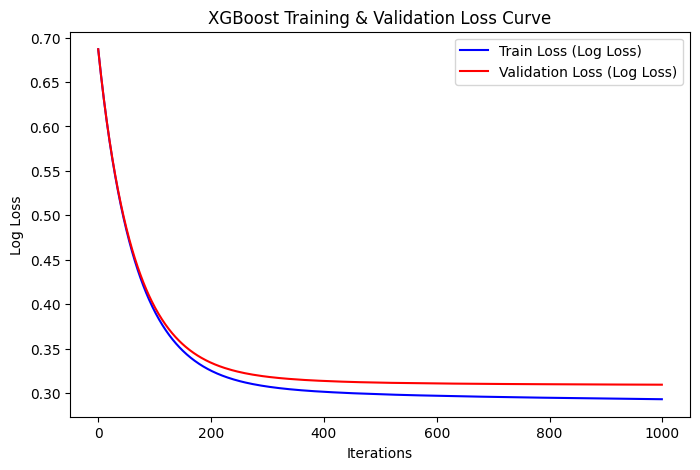

üîπ Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89    299557
           1       0.54      0.94      0.69     72596

    accuracy                           0.83    372153
   macro avg       0.76      0.88      0.79    372153
weighted avg       0.90      0.83      0.85    372153



In [177]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss Ï†ÄÏû•
    verbose=True
)

# 3Ô∏è‚É£ ÌïôÏäµ Í≥ºÏ†ïÏóêÏÑú Ï†ÄÏû•Îêú Train & Validation Loss Í∞ÄÏ†∏Ïò§Í∏∞
evals_result = model.evals_result()  # üîπ Î≥ÄÍ≤ΩÎêú ÏΩîÎìú (ÌïôÏäµ ÌõÑ Í≤∞Í≥º ÌôïÏù∏)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4Ô∏è‚É£ Train & Validation Loss ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5Ô∏è‚É£ ÏòàÏ∏° Î∞è ÌèâÍ∞Ä
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRCÏóê ÌïÑÏöî

threshold = 0.3
y_pred = (y_prob >= threshold).astype(int)

# üîπ Classification Report Ï∂úÎ†•
print("üîπ Classification Report:")
print(classification_report(y_test, y_pred))

# 6Ô∏è‚É£ ROC Curve & AUC-ROC Í≥ÑÏÇ∞
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7Ô∏è‚É£ Precision-Recall Curve & AU-PRC Í≥ÑÏÇ∞
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [178]:
from sklearn.metrics import confusion_matrix
# confusion matrix Í≥ÑÏÇ∞
cm = confusion_matrix(y_test, y_pred)

# Ìñâ: Ïã§Ï†úÍ∞í (y_test), Ïó¥: ÏòàÏ∏°Í∞í (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("‚úÖ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

‚úÖ Confusion Matrix
[[242200  57357]
 [  4210  68386]]

True Positives (TP): 68386
False Positives (FP): 57357
True Negatives (TN): 242200
False Negatives (FN): 4210


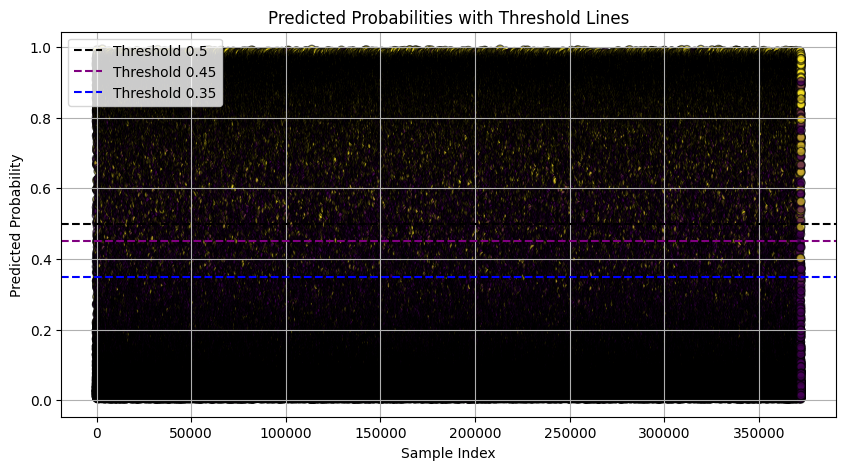

In [179]:
# ÌôïÎ•† vs ÌÅ¥ÎûòÏä§ ÏãúÍ∞ÅÌôî (2D Scatter)
y_test_1d = y_test.iloc[:, 0] if isinstance(y_test, pd.DataFrame) else y_test

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(y_prob)), y_prob, c=y_test_1d, alpha=0.6, edgecolors='k')
plt.axhline(y=0.5, color='black', linestyle='--', label='Threshold 0.5')
plt.axhline(y=0.45, color='purple', linestyle='--', label='Threshold 0.45')
plt.axhline(y=0.35, color='blue', linestyle='--', label='Threshold 0.35')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities with Threshold Lines')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()


## Oversampling

In [180]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

In [181]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x_scaled, data_y, test_size=0.33, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 997369 samples (67.0%)
Validation size: 491242 samples (33.0%)
Test size: 372153 samples (25.0%)


In [182]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# SMOTE Í∞ùÏ≤¥ ÏÉùÏÑ±
smote = SMOTE(random_state=42)

# Ïò§Î≤ÑÏÉòÌîåÎßÅ ÏàòÌñâ
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Í≤∞Í≥º ÌôïÏù∏
print(f"‚úÖ SMOTE Ï†ÅÏö© ÏôÑÎ£å")
print(f"üì¶ X_train_smote shape: {X_train_smote.shape}")
print(y_train_smote.value_counts())

## Ï¶ùÍ∞ï ÏãúÍ∞ÑÏù¥ Ïò§Îûò Í±∏Î¶¨Í∏∞ ÎïåÎ¨∏ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•ÏùÑ ÌïúÎã§.
augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)

‚úÖ SMOTE Ï†ÅÏö© ÏôÑÎ£å
üì¶ X_train_smote shape: (1605622, 18)
loan_status
0              802811
1              802811
Name: count, dtype: int64


In [183]:
X_train = augmentation_data.drop(columns='loan_status')
y_train = augmentation_data[['loan_status']]

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ‚úÖ `.values`Î°ú NumPy Î∞∞Ïó¥ Î≥ÄÌôò
#scale_pos_weight = neg / pos  # ÌÅ¥ÎûòÏä§ ÎπÑÏú® Í≥ÑÏÇ∞

# 1Ô∏è‚É£ XGBoost Î™®Îç∏ Ï†ïÏùò
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.68673	validation_1-logloss:0.68681
[1]	validation_0-logloss:0.68044	validation_1-logloss:0.68060
[2]	validation_0-logloss:0.67427	validation_1-logloss:0.67451
[3]	validation_0-logloss:0.66822	validation_1-logloss:0.66854
[4]	validation_0-logloss:0.66229	validation_1-logloss:0.66270
[5]	validation_0-logloss:0.65647	validation_1-logloss:0.65696
[6]	validation_0-logloss:0.65076	validation_1-logloss:0.65134
[7]	validation_0-logloss:0.64516	validation_1-logloss:0.64583
[8]	validation_0-logloss:0.63966	validation_1-logloss:0.64042
[9]	validation_0-logloss:0.63426	validation_1-logloss:0.63511
[10]	validation_0-logloss:0.62896	validation_1-logloss:0.62990
[11]	validation_0-logloss:0.62377	validation_1-logloss:0.62479
[12]	validation_0-logloss:0.61866	validation_1-logloss:0.61978
[13]	validation_0-logloss:0.61365	validation_1-logloss:0.61486
[14]	validation_0-logloss:0.60872	validation_1-logloss:0.61002
[15]	validation_0-logloss:0.60389	validation_1-logloss:0.60528
[1

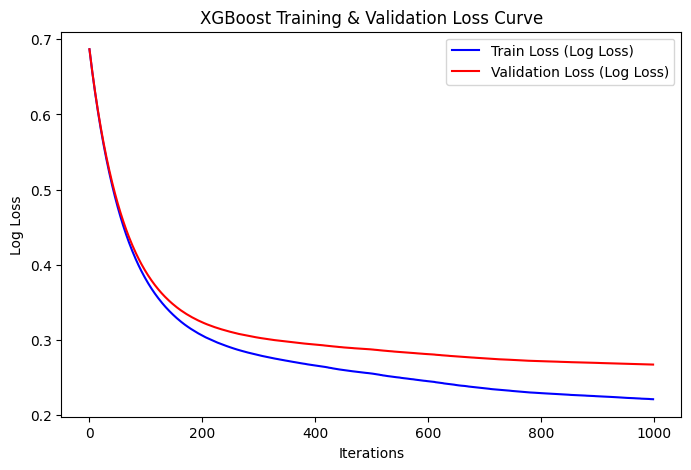

üîπ Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91    299557
           1       0.59      0.91      0.72     72596

    accuracy                           0.86    372153
   macro avg       0.79      0.88      0.81    372153
weighted avg       0.90      0.86      0.87    372153



In [185]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss Ï†ÄÏû•
    verbose=True
)

# 3Ô∏è‚É£ ÌïôÏäµ Í≥ºÏ†ïÏóêÏÑú Ï†ÄÏû•Îêú Train & Validation Loss Í∞ÄÏ†∏Ïò§Í∏∞
evals_result = model.evals_result()  # üîπ Î≥ÄÍ≤ΩÎêú ÏΩîÎìú (ÌïôÏäµ ÌõÑ Í≤∞Í≥º ÌôïÏù∏)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4Ô∏è‚É£ Train & Validation Loss ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5Ô∏è‚É£ ÏòàÏ∏° Î∞è ÌèâÍ∞Ä
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRCÏóê ÌïÑÏöî

threshold = 0.3
y_pred = (y_prob >= threshold).astype(int)

# üîπ Classification Report Ï∂úÎ†•
print("üîπ Classification Report:")
print(classification_report(y_test, y_pred))

# 6Ô∏è‚É£ ROC Curve & AUC-ROC Í≥ÑÏÇ∞
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7Ô∏è‚É£ Precision-Recall Curve & AU-PRC Í≥ÑÏÇ∞
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [186]:
from sklearn.metrics import confusion_matrix
# confusion matrix Í≥ÑÏÇ∞
cm = confusion_matrix(y_test, y_pred)

# Ìñâ: Ïã§Ï†úÍ∞í (y_test), Ïó¥: ÏòàÏ∏°Í∞í (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("‚úÖ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

‚úÖ Confusion Matrix
[[254163  45394]
 [  6184  66412]]

True Positives (TP): 66412
False Positives (FP): 45394
True Negatives (TN): 254163
False Negatives (FN): 6184


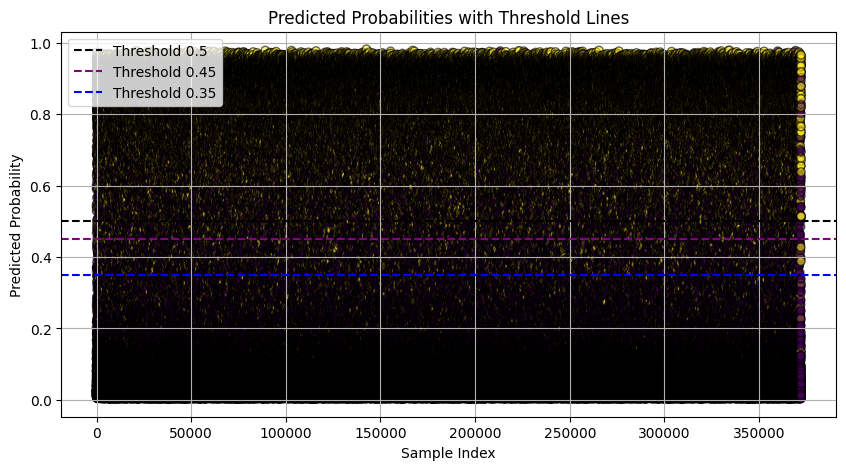

In [187]:
# ÌôïÎ•† vs ÌÅ¥ÎûòÏä§ ÏãúÍ∞ÅÌôî (2D Scatter)
y_test_1d = y_test.iloc[:, 0] if isinstance(y_test, pd.DataFrame) else y_test

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(y_prob)), y_prob, c=y_test_1d, alpha=0.6, edgecolors='k')
plt.axhline(y=0.5, color='black', linestyle='--', label='Threshold 0.5')
plt.axhline(y=0.45, color='purple', linestyle='--', label='Threshold 0.45')
plt.axhline(y=0.35, color='blue', linestyle='--', label='Threshold 0.35')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities with Threshold Lines')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()


## Tablegan

In [188]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

In [189]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x_scaled, data_y, test_size=0.33, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 997369 samples (67.0%)
Validation size: 491242 samples (33.0%)
Test size: 372153 samples (25.0%)


In [190]:
train_dataset = pd.concat([X_train, y_train], axis=1)

fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/train/train_OI_11_00_fake.csv"
fake = pd.read_csv(fake_path)
fake['loan_status'] = 1

X_fake = fake.drop(columns='loan_status')
y_fake = fake[['loan_status']]

In [191]:
## Train set Î∞îÍæ∏Í∏∞Í∏∞
fake['annual_inc_adj'] = fake['annual_inc'].replace(0, 1e-6)

# 1. Î∂ÄÏ±Ñ ÎåÄÎπÑ ÏÜåÎìù ÎπÑÏú® (DTI ratio - Ïõî ÏÜåÎìù Í∏∞Ï§Ä)
fake['debt_to_income_ratio'] = fake['installment'] / (fake['annual_inc_adj'] / 12)

# 2. Î¶¨Î≥ºÎπô ÌôúÏö©ÎèÑ (Ï¥ù ÌïúÎèÑ ÎåÄÎπÑ ÏÇ¨Ïö© ÎπÑÏú®)
fake['total_rev_hi_lim_adj'] = fake['total_rev_hi_lim'].replace(0, 1e-6)
fake['utilization_ratio'] = fake['revol_bal'] / fake['total_rev_hi_lim_adj']

# 3. Í∞ÄÏö© Ïã†Ïö© ÎπÑÏú® (ÎÇ®ÏùÄ Ïã†Ïö© ÌïúÎèÑ ÎπÑÏú®)
fake['open_to_limit_ratio'] = fake['bc_open_to_buy'] / fake['total_rev_hi_lim_adj']

# ‚úÖ ÌïÑÏöî ÏóÜÏñ¥ÏßÑ Î≥¥Ï†ï Ïª¨Îüº Ï†úÍ±∞
fake.drop(columns=['annual_inc_adj', 'total_rev_hi_lim_adj'], inplace=True)

X_fake = fake.drop(columns='loan_status')
y_fake = fake[['loan_status']]

In [192]:
"""to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']

scaler_2 = StandardScaler()
X_fake_scaled = X_fake.copy()
X_fake_scaled[to_scale] = scaler.fit_transform(X_fake_scaled[to_scale])"""

"to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']\n\nscaler_2 = StandardScaler()\nX_fake_scaled = X_fake.copy()\nX_fake_scaled[to_scale] = scaler.fit_transform(X_fake_scaled[to_scale])"

In [193]:
to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']
X_fake_scaled = X_fake.copy()

for col in to_scale:
    X_fake_scaled[col] = np.log1p(X_fake_scaled[col])  # log(1 + x) ‚Üí 0 Í∞í ÎåÄÏùë

In [194]:
fake = pd.concat([X_fake_scaled, y_fake], axis= 1)

In [195]:
from sklearn.utils import shuffle

train_total = pd.concat([train_dataset,fake])
train_total = shuffle(train_total, random_state=42)

In [196]:
X_train = train_total.drop(columns='loan_status')
y_train = train_total[['loan_status']]

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ‚úÖ `.values`Î°ú NumPy Î∞∞Ïó¥ Î≥ÄÌôò
#scale_pos_weight = neg / pos  # ÌÅ¥ÎûòÏä§ ÎπÑÏú® Í≥ÑÏÇ∞

# 1Ô∏è‚É£ XGBoost Î™®Îç∏ Ï†ïÏùò
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.67395	validation_1-logloss:0.78998
[1]	validation_0-logloss:0.66678	validation_1-logloss:0.78147
[2]	validation_0-logloss:0.65975	validation_1-logloss:0.77316
[3]	validation_0-logloss:0.65288	validation_1-logloss:0.76504
[4]	validation_0-logloss:0.64613	validation_1-logloss:0.75711
[5]	validation_0-logloss:0.63953	validation_1-logloss:0.74935
[6]	validation_0-logloss:0.63304	validation_1-logloss:0.74176
[7]	validation_0-logloss:0.62669	validation_1-logloss:0.73433
[8]	validation_0-logloss:0.62046	validation_1-logloss:0.72707
[9]	validation_0-logloss:0.61434	validation_1-logloss:0.71996
[10]	validation_0-logloss:0.60834	validation_1-logloss:0.71298
[11]	validation_0-logloss:0.60244	validation_1-logloss:0.70616
[12]	validation_0-logloss:0.59667	validation_1-logloss:0.69949
[13]	validation_0-logloss:0.59099	validation_1-logloss:0.69294
[14]	validation_0-logloss:0.58542	validation_1-logloss:0.68653
[15]	validation_0-logloss:0.57995	validation_1-logloss:0.68026
[1

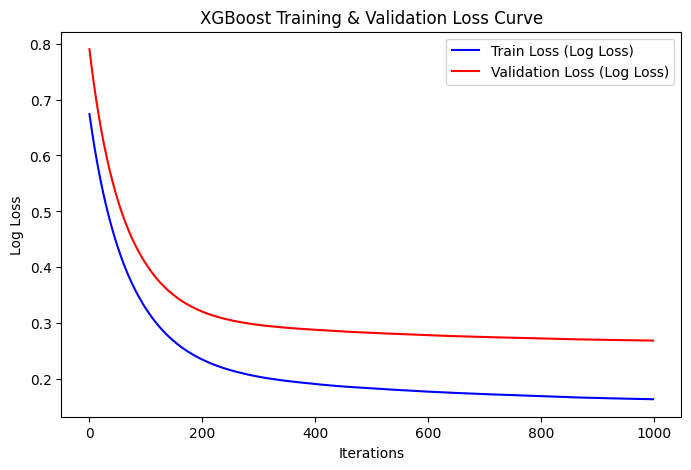

üîπ Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91    299557
           1       0.61      0.89      0.72     72596

    accuracy                           0.87    372153
   macro avg       0.79      0.87      0.82    372153
weighted avg       0.90      0.87      0.88    372153



In [198]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss Ï†ÄÏû•
    verbose=True
)

# 3Ô∏è‚É£ ÌïôÏäµ Í≥ºÏ†ïÏóêÏÑú Ï†ÄÏû•Îêú Train & Validation Loss Í∞ÄÏ†∏Ïò§Í∏∞
evals_result = model.evals_result()  # üîπ Î≥ÄÍ≤ΩÎêú ÏΩîÎìú (ÌïôÏäµ ÌõÑ Í≤∞Í≥º ÌôïÏù∏)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4Ô∏è‚É£ Train & Validation Loss ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5Ô∏è‚É£ ÏòàÏ∏° Î∞è ÌèâÍ∞Ä
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRCÏóê ÌïÑÏöî

threshold = 0.3
y_pred = (y_prob >= threshold).astype(int)

# üîπ Classification Report Ï∂úÎ†•
print("üîπ Classification Report:")
print(classification_report(y_test, y_pred))

# 6Ô∏è‚É£ ROC Curve & AUC-ROC Í≥ÑÏÇ∞
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7Ô∏è‚É£ Precision-Recall Curve & AU-PRC Í≥ÑÏÇ∞
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [199]:
from sklearn.metrics import confusion_matrix
# confusion matrix Í≥ÑÏÇ∞
cm = confusion_matrix(y_test, y_pred)

# Ìñâ: Ïã§Ï†úÍ∞í (y_test), Ïó¥: ÏòàÏ∏°Í∞í (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("‚úÖ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

‚úÖ Confusion Matrix
[[258759  40798]
 [  8284  64312]]

True Positives (TP): 64312
False Positives (FP): 40798
True Negatives (TN): 258759
False Negatives (FN): 8284


<Figure size 1000x800 with 0 Axes>

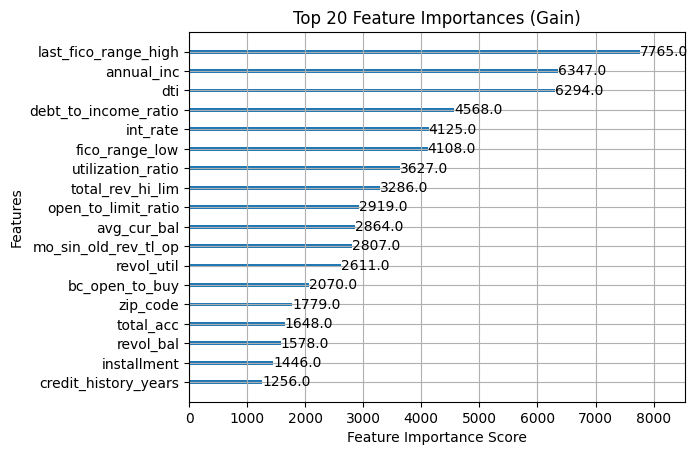

In [200]:
###xgboost feature gain ÌôïÏù∏
import xgboost as xgb
# 8Ô∏è‚É£ Feature Importance Ï∂îÏ∂ú Î∞è ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞ Î∞©Î≤ï: 'weight', 'gain', 'cover' Ï§ë ÏÑ†ÌÉù Í∞ÄÎä•
    max_num_features=20,     # ÏÉÅÏúÑ 20Í∞ú featureÎßå ÌëúÏãú
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()